In [12]:
import mlflow
import numpy as np
import pandas as pd
import pickle
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata
import gc

In [13]:
class SHAP():
    def __init__(self, dataset_name, pipe):
        self.dataset_name_ = dataset_name
        self.pipe_ = pipe
        
    def _get_features(self, df):
        out_cols = ["user_id", "row_id", "time_step", "pipe"]+\
            [c for c in df.columns if "target_" in c]
        return [c for c in df.columns if c not in out_cols] 
    
    def get_data(self):
        values = spark.table(f"churndb.{self.dataset_name_}_shap_values")\
            .where(f.col("pipe")==self.pipe_).orderBy(f.col("row_id"))
        self.feature_names = self._get_features(values)
        self.values = values.select(self.feature_names)\
            .toPandas().values
        data = spark.table(f"churndb.{self.dataset_name_}_shap_data")\
           .where(f.col("pipe")==self.pipe_).orderBy(f.col("row_id"))        
        self.data = data.select(self.feature_names)\
            .toPandas().values
        return self
    
    def save_data(self, path=None):
        if path is None:
            path = f"/dbfs/mnt/{self.dataset_name_}/pipelines/shap_{self.pipe_}"
        with open(path, "wb") as f:
            pickle.dump(self, f)

In [14]:
with open("../data/rees46/pipelines/shap_gbm_class", "rb") as f:
   shap_values = pickle.load(f)

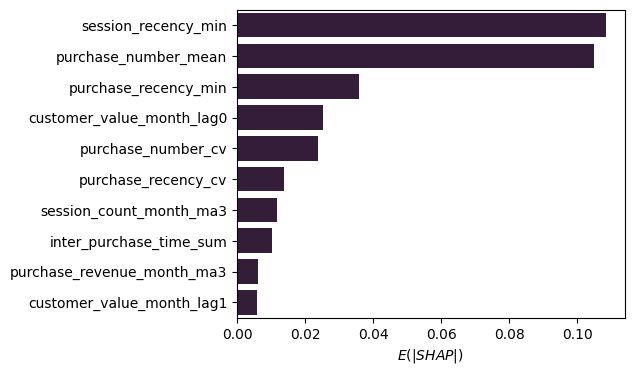

In [15]:
%matplotlib inline
def plot_feature_importance(shap_values, max_features=10, figsize=(5,4)):
    # data
    values = pd.DataFrame(shap_values.values, columns=shap_values.feature_names)
    importance = values.abs().mean().sort_values(ascending=False)\
        .head(max_features).reset_index()
    importance.columns = ["variable", "shap"]

    # plot
    f, a = plt.subplots(1,1, figsize=figsize)
    sns.barplot(x=importance.shap, y=importance.variable,
        color=sns.color_palette("rocket")[0], ax=a);
    a.set_ylabel("");
    a.set_xlabel("$E(|SHAP|)$");

plot_feature_importance(shap_values)    

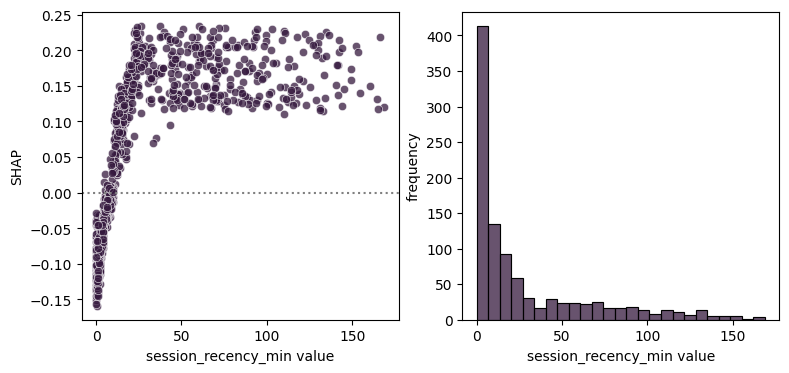

In [16]:
%matplotlib inline
def plot_feature(shap_values, feature_name=None, xlim=None, figsize=(9,4)):
    # data
    cf = [c==feature_name for c in shap_values.feature_names]
    y = shap_values.values[:,cf].reshape(-1)
    x = shap_values.data[:,cf].reshape(-1)
    range = (np.max(x)-np.min(x))
    if xlim is not None:
        range = xlim[1]-xlim[0]
    # plots
    f, axs = plt.subplots(1,2, figsize=figsize)
    sns.scatterplot(x=x,y=y, ax=axs[0],
        color=sns.color_palette("rocket")[0], alpha=.75)
    sns.histplot(x=x, ax=axs[1], binwidth=range/25,
        color=sns.color_palette("rocket")[0])
    axs[0].set_xlim(xlim)
    axs[0].set_ylabel("SHAP")
    axs[0].set_xlabel(feature_name+" value")
    axs[0].axline((0,0), slope=0, color="gray", linestyle="dotted")
    #axs[0].ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    axs[1].set_xlim(xlim)
    axs[1].set_ylabel("frequency")
    axs[1].set_xlabel(feature_name+" value")
    #axs[1].ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    return None

plot_feature(shap_values, "session_recency_min", xlim=None)

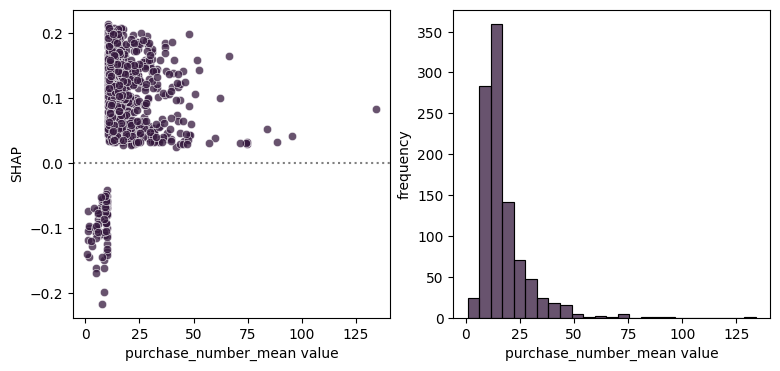

In [17]:
%matplotlib inline
plot_feature(shap_values, "purchase_number_mean")

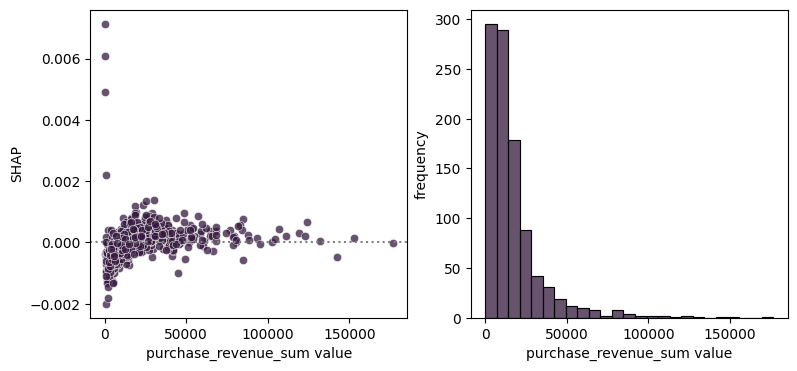

In [18]:
%matplotlib inline
plot_feature(shap_values, "purchase_revenue_sum")

In [19]:
def set_lims(mat, lims):
    if lims is None:
        return mat
    else:
        mat[(mat<lims[0])|(mat>lims[1])] =  np.nan
        return mat

def plot_feature_interactions(shap_values, feature_name1=None, feature_name2=None,
    tiles=15, limits=None, figsize=(10,8)):

    c1 = [c==feature_name1 for c in shap_values.feature_names]
    c2 = [c==feature_name2 for c in shap_values.feature_names]
    shv = np.sum(shap_values.values[:,np.logical_or(c1,c2)], axis=1)
    fv1 = shap_values.data[:,c1].reshape(-1)
    fv2 = shap_values.data[:,c2].reshape(-1)

    plotx, ploty = np.meshgrid(
        np.linspace(np.min(fv1),np.max(fv1),tiles),
        np.linspace(np.min(fv2),np.max(fv2),tiles))
    plotz = griddata((fv1,fv2), shv, (plotx, ploty))

    if limits is not None:
        if "x" in limits.keys():
            plotx = set_lims(plotx, limits["x"])
        if "y" in limits.keys():
            ploty = set_lims(ploty, limits["y"])
        if "z" in limits.keys():
            plotz = set_lims(plotz, limits["z"])

    f = plt.figure(figsize=figsize)
    ax = f.add_subplot(111, projection="3d")
    ax.plot_surface(plotx, ploty, plotz, cmap="rocket");
    ax.set_xlabel(feature_name1, labelpad=6);
    ax.set_ylabel(feature_name2, labelpad=6);
    ax.set_zlabel("SHAP", labelpad=6);
    f.tight_layout();
    return None

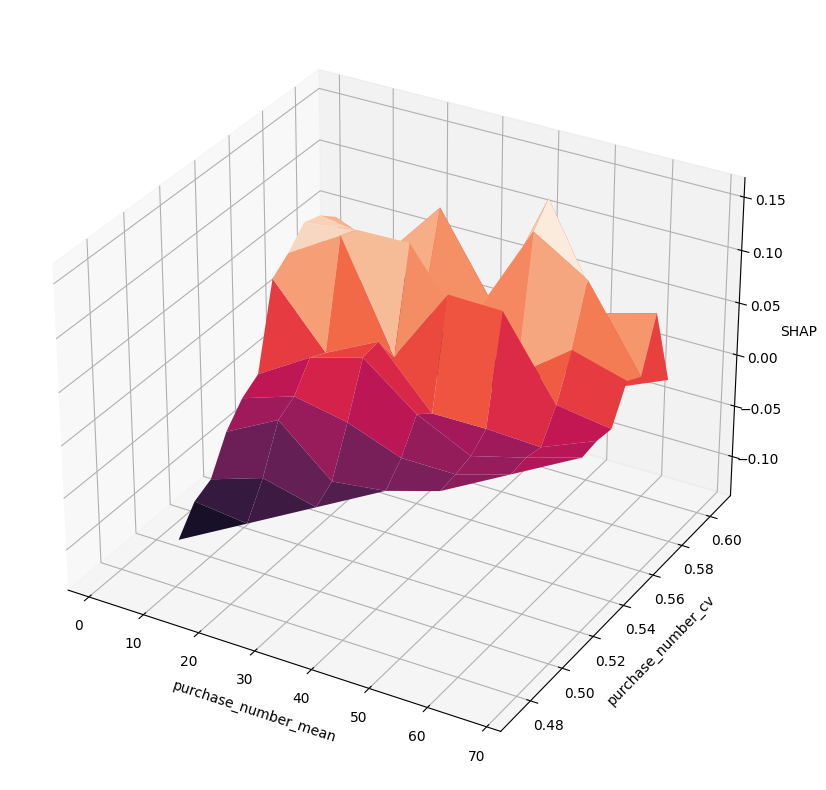

In [20]:
%matplotlib inline
plot_feature_interactions(shap_values, "purchase_number_mean",
    "purchase_number_cv", tiles=15, limits={"x":(0,75), })

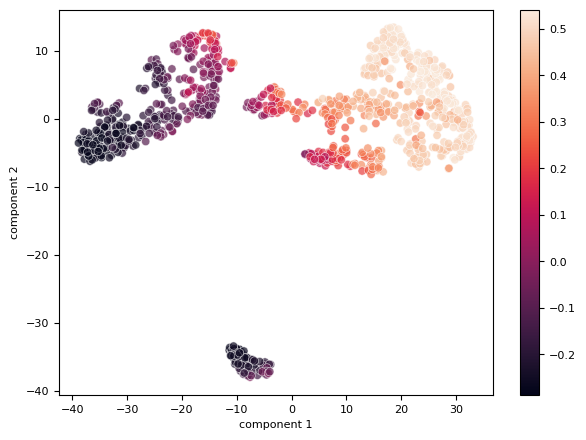

In [21]:
# ENCLOSE THIS
%matplotlib inline
from sklearn.manifold import TSNE

def plot_observations(shap_values, figsize=(7,5), tsne_kw={
    "perplexity":50, "learning_rate":35, "n_iter":1000,
        "init":"random", "random_state":1}):
    # data
    shap_total = np.sum(shap_values.values, axis=1)
    tsne = TSNE(**tsne_kw)
    shap_transformed = tsne.fit_transform(shap_values.values)

    # plot
    plt.rcParams.update({"font.size": 8, "axes.titlesize":8})
    f, a = plt.subplots(1,1, figsize=figsize)
    sns.scatterplot(x=shap_transformed[:,0], y=shap_transformed[:,1],
        hue=shap_total, palette="rocket", alpha=.7, 
        ax=a, legend=False);
    a.set_xlabel("component 1");
    a.set_ylabel("component 2");

    norm = plt.Normalize(np.max(shap_total), np.min(shap_total));
    sm = plt.cm.ScalarMappable(cmap="rocket", norm=norm);
    sm.set_array([]);
    a.figure.colorbar(sm);
    plt.rcParams.update(plt.rcParamsDefault);

plot_observations(shap_values)

In [22]:
# get silh
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score

def get_inertia(df):
    dist = pairwise_distances(df.values,
        df.mean().values.reshape(1,-1))
    return np.sum(np.array(dist))

def evaluate_clustering(shap_values, range=range(3,10)):
    df = pd.DataFrame(shap_values.values,
        columns=shap_values.feature_names)
    score_dict = {}
    for n_clusters in range:
        clustering_fit = AgglomerativeClustering(n_clusters=n_clusters)
        cluster_labels = clustering_fit.fit_predict(df)
        silh_score = silhouette_score(df, cluster_labels)
        intert_score = df.groupby(cluster_labels).apply(get_inertia).sum()
        score_dict[n_clusters] = {"silhouette_score":silh_score,
            "inertia_score":intert_score}
    score_df = pd.DataFrame.from_dict(score_dict).T.reset_index()
    score_df.columns = ["n_clusters"]+ list(score_df.columns[1:])
    return score_df

cluster_scores = evaluate_clustering(shap_values)
cluster_scores

,n_clusters,silhouette_score,inertia_score
0,3,0.564875,66.175751
1,4,0.489922,57.642375
2,5,0.314203,52.690278
3,6,0.304673,49.589747
4,7,0.296247,46.776533
5,8,0.291957,45.425852
6,9,0.277161,43.866442


This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


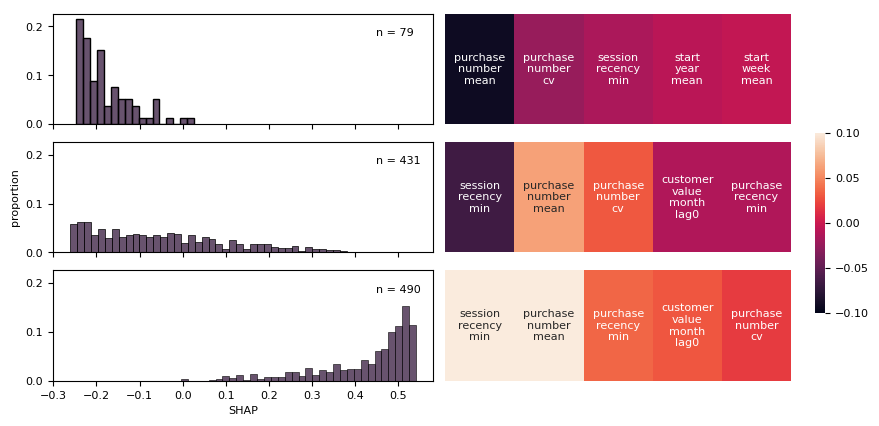

In [29]:
%matplotlib inline

def plot_clusters(shap_values, cluster_labels, max_features=5,
    vex=(-1,1), lal="right",figsize=(7.5,4.5)):

    n_clusters = len(set(cluster_labels))
    shap_total = np.sum(shap_values.values, axis=1)
    df = pd.DataFrame(shap_values.values,
        columns=shap_values.feature_names)

    new_labels = pd.DataFrame(shap_total).groupby(cluster_labels).mean()\
        .sort_values(0).reset_index().to_dict()["index"]
    new_labels = {v:k for k, v in new_labels.items()}    
    cluster_labels = np.array([new_labels[c] for c in cluster_labels])

    plt.rcParams.update({"font.size": 8, "axes.titlesize":8})
    f = plt.figure(figsize=figsize)
    subfigs = f.subfigures(1, 2, width_ratios=[1.1, 1])

    # left plot
    la = subfigs[0].subplots(n_clusters, 1, sharey=True, sharex=True)
    for cluster in range(n_clusters):
        sns.histplot(x=shap_total[cluster_labels==cluster],
            ax=la[cluster], binwidth=(np.max(shap_total)-np.min(shap_total))/50,
            stat="proportion", color=sns.color_palette("rocket")[0], alpha=.75)
        la[cluster].set_ylabel("")

    # add axis labels
    subfigs[0].add_subplot(111, frameon=False)
    plt.tick_params(labelcolor="none", which="both",
        top=False, bottom=False, left=False, right=False)
    plt.xlabel("SHAP");
    plt.ylabel("proportion");
    # add labels after axis adjustment
    mlal = 0.85
    if lal == "left":
        mlal = 0.02
    for cluster in range(n_clusters):
        xlims = la[cluster].get_xlim()
        ylims = la[cluster].get_ylim()
        la[cluster].text(x=xlims[0]+(xlims[1]-xlims[0])*mlal,
            y=ylims[0]+(ylims[1]-ylims[0])*0.8,
            s=f"n = {len(shap_total[cluster_labels==cluster])}")
    # right plot
    ra = subfigs[1].subplots(n_clusters, 1,)
    cbar_ax = subfigs[1].add_axes([1.05, .30, .03, .40])
    for cluster in range(n_clusters):
        cluster_data = df.loc[cluster_labels==cluster,:].mean()
        feature_order = cluster_data.abs().sort_values(ascending=False).head(max_features)
        plot_data = pd.DataFrame(cluster_data.loc[feature_order.index], columns=["shap"]).T
        sns.heatmap(plot_data, ax=ra[cluster],
            cbar=True, vmin=vex[0], vmax=vex[1], cbar_ax=cbar_ax,
            yticklabels="", xticklabels="",
            annot=np.array(["\n".join(c) for c in plot_data.columns.str.split("_")])\
                .reshape(plot_data.shape),
            annot_kws={"rotation":0}, fmt="");
    f.tight_layout();
    plt.rcParams.update(plt.rcParamsDefault);

clustering_fit = AgglomerativeClustering(n_clusters=3)
cluster_labels = clustering_fit.fit_predict(shap_values.values)
plot_clusters(shap_values, cluster_labels, vex=(-0.1,0.1), lal="right")

In [14]:
from sklearn.metrics import pairwise_distances_argmin
def get_cluster_centers(df):
    min_row = pairwise_distances_argmin(df.values,
        df.mean().values.reshape(1,-1),
        axis=0)
    return df.iloc[min_row,:].index.values[0]

cluster_centers = pd.DataFrame(shap_values.values,
    columns=shap_values.feature_names)
# cf = (cluster_centers.sum(axis=1)+shap_values.base_values[0])>5
# cluster_centers = cluster_centers.loc[cf,:]
# cluster_labels = [1]*cluster_centers.shape[0]    
cluster_centers=cluster_centers\
        .groupby(cluster_labels, as_index=False)\
        .apply(get_cluster_centers).reset_index()
cluster_centers.columns = ["cluster_label", "idx"]
cluster_centers

,cluster_label,idx
0,0,784
1,1,505
2,2,160


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


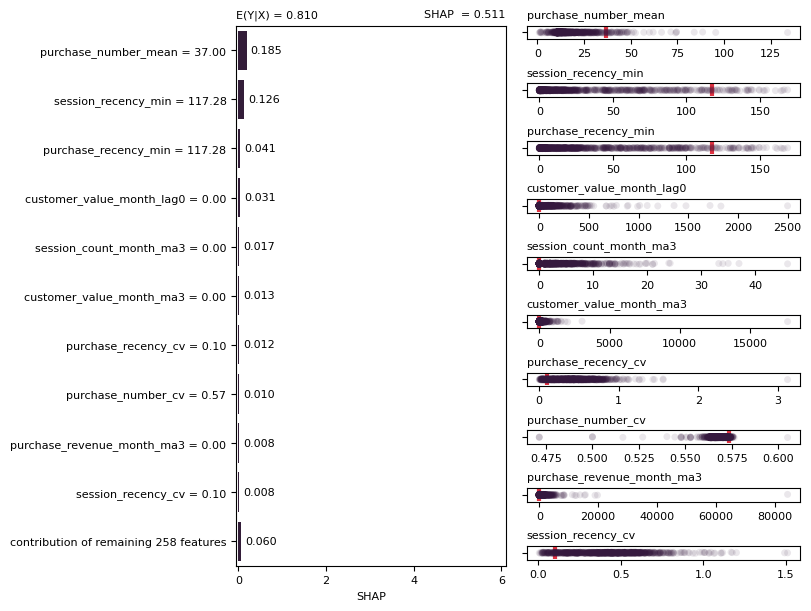

In [38]:
%matplotlib inline
def plot_observation(shap_values, row, max_features=5,
    shap_xlim=(-.1,.1), dec_title=2, dec_feats=2):

    # data
    shap_row = pd.DataFrame(shap_values.values[row,:].reshape(1,-1),
        columns=shap_values.feature_names, index=["shap"]).T
    feature_names = shap_row.abs().sort_values("shap", ascending=False).head(max_features).index
    feature_comp_names = [i for i in shap_row.index if i not in feature_names]
    complement_shap = shap_row.loc[feature_comp_names,:].sum()
    complement_shap.name = f"contribution of remaining {len(feature_comp_names)} features"
    total_shap = shap_row.sum()
    total_shap.name = "shap expected"
    base_value = shap_values.base_values[row]+total_shap.values[0]
    feature_shaps = shap_row.loc[feature_names,:]\
        .append(complement_shap, ignore_index=False)
    feature_shaps = pd.DataFrame(feature_shaps).reset_index()\
        .rename(columns={"index":"name"})
    feature_values = pd.DataFrame(shap_values.data,
        columns=shap_values.feature_names)
    feature_values.loc[row,feature_names]
    feature_values = feature_values.loc[row,feature_names]
    feature_labels = [feature_values.index[i]+" = {:.{}f}".format(v, dec_feats)
        if np.abs(v)<10000 else feature_values.index[i]+" = {:.2e}".format(v)
            for i,v in enumerate(feature_values)]+[complement_shap.name]

    plt.rcParams.update({"font.size": 8, "axes.titlesize":8})
    f = plt.figure(constrained_layout=True, figsize=(8, 6))
    subfigs = f.subfigures(1, 2, width_ratios=[1.75, 1])

    # left plot
    la = subfigs[0].subplots(1,1) 
    cust_pal = {feature_shaps.name[v]:sns.color_palette("rocket")[0]\
        if feature_shaps.shap[v]>0 else sns.color_palette("rocket")[3]\
            for v in feature_shaps.index}
    a = sns.barplot(data=feature_shaps, x="shap", y="name",
        palette=cust_pal, ax=la)
    a.set_title("E(Y|X) = {:.{}f}".format(base_value, dec_title), loc="left")
    a.set_title("SHAP  = {:.{}f}".format(total_shap.values[0], dec_title), loc="right")
    a.set_ylabel("");
    a.set_yticklabels(feature_labels);
    a.set_xlabel("SHAP");
    a.set_xlim(shap_xlim);
    for container in a.containers:
        a.bar_label(container, fmt="%.{}f".format(dec_title), padding=3)

    # right plot
    feature_values = pd.DataFrame(shap_values.data,
        columns=shap_values.feature_names)        
    ra = subfigs[1].subplots(max_features+1, 1, gridspec_kw={"hspace":.10})    
    for i in range(max_features):
        a = sns.stripplot(data=feature_values, x=feature_names[i],
            color=sns.color_palette("rocket")[0], alpha=.1, ax=ra.flat[i])
        a.vlines(feature_values.loc[row, feature_names[i]], -1, 1,
            color=sns.color_palette("rocket")[3], linestyles="solid", linewidths=3)
        a.set_xlabel("");
        a.set_title(feature_names[i], loc="left");
    # hack with additional subplot
    ra[-1].set_frame_on(False)
    ra[-1].get_xaxis().set_ticks([])
    ra[-1].get_yaxis().set_ticks([])    
    plt.rcParams.update(plt.rcParamsDefault)

#plot_observation(shap_values,936,5,shap_xlim=(-2.75, 1.25))
plot_observation(shap_values,166,10,shap_xlim=(-0.05, 6.1),
    dec_title=3, dec_feats=2)